# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd

from utils.gaussian_processes.gp_model import GPModel

2023-02-19 16:25:20.207120: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-19 16:25:20.813391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-19 16:25:20.813456: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-19 16:25:20.813463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make su

# Data

In [2]:
# Load the data
# Load the data from the Scripps CO2 program website. 
co2_df = pd.read_csv(
    # Source: https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv
    './monthly_in_situ_co2_mlo.csv', 
    header=3, # Data starts here
    skiprows=[4, 5], # Headers consist of multiple rows
    usecols=[3, 4], # Only keep the 'Date' and 'CO2' columns
    na_values='-99.99',  # NaNs are denoted as '-99.99'
    dtype=np.float64
)

# Drop missing values
co2_df.dropna(inplace=True)
# Remove whitespace from column names
co2_df.rename(columns=lambda x: x.strip(), inplace=True)


# Split the data into observed and to predict
date_split_predict = 2010
df_observed = co2_df[co2_df.Date < date_split_predict]
print('{} measurements in the observed set'.format(len(df_observed)))
df_predict = co2_df[co2_df.Date >= date_split_predict]
print('{} measurements in the test set'.format(len(df_predict)))

617 measurements in the observed set
133 measurements in the test set


In [3]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 624 to 756
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    133 non-null    float64
 1   CO2     133 non-null    float64
dtypes: float64(2)
memory usage: 3.1 KB


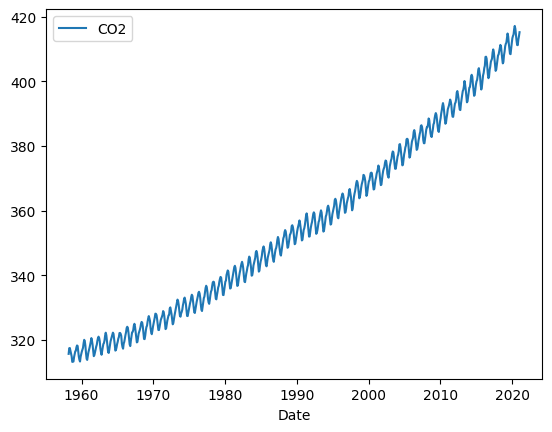

In [4]:
co2_df.plot(x="Date", y="CO2");

# Gaussian Process

In [5]:
gp_model = GPModel()

In [6]:
gp_model.fit(df_observed=df_observed, x_col="Date", y_col="CO2", epochs=1000)

from dataloader.load_regression_data import RegressionDataGenerator

  0%|          | 0/1000 [00:00<?, ?it/s]

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


loss = 191.887: 100%|██████████| 1000/1000 [00:12<00:00, 77.91it/s]


# DataGenerator

In [7]:
data_generator = RegressionDataGenerator(gp_model=gp_model,
                                         df_predict=df_predict)

(<Figure size 800x500 with 1 Axes>, <AxesSubplot: >)

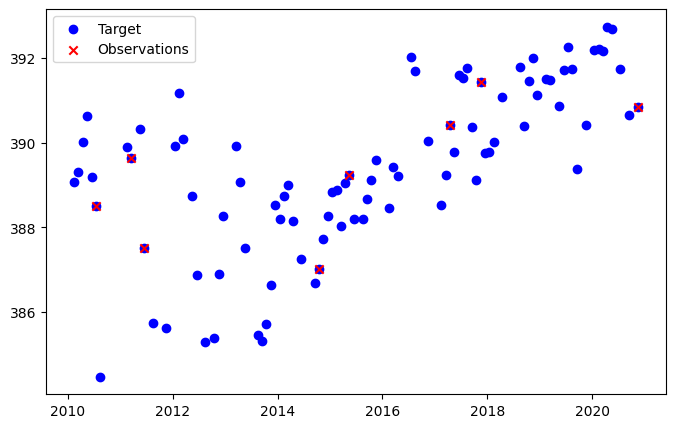

In [8]:
data_generator.plot_first_elt_of_random_batch()

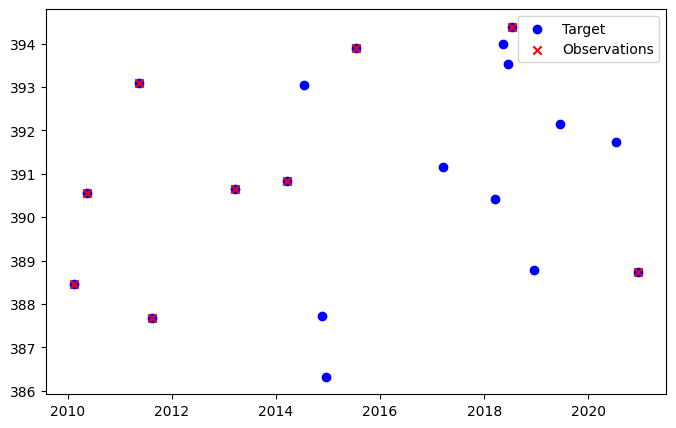

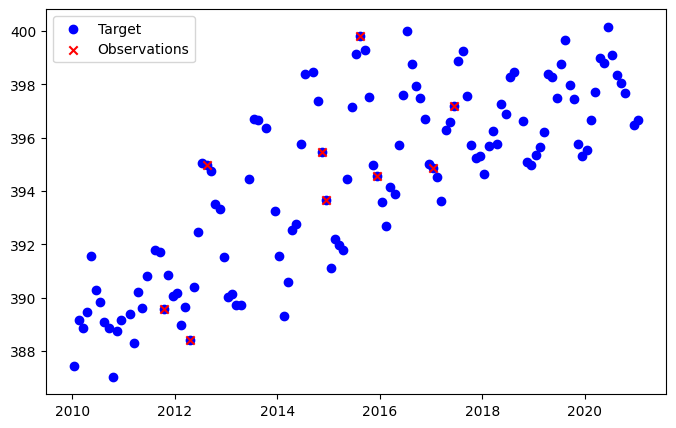

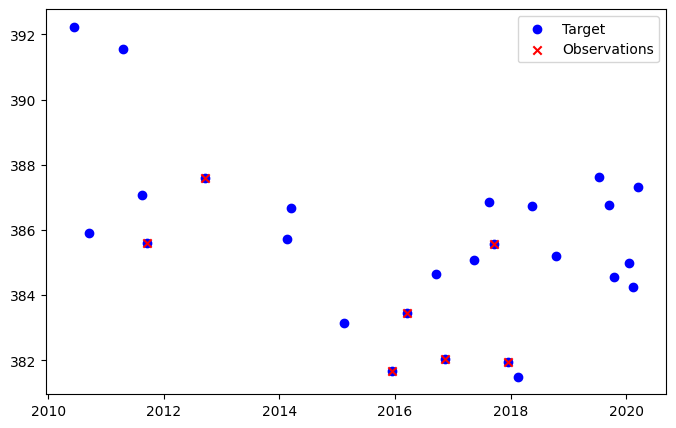

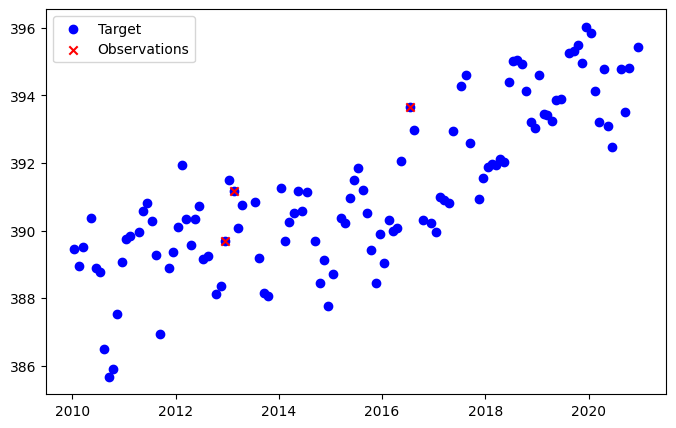

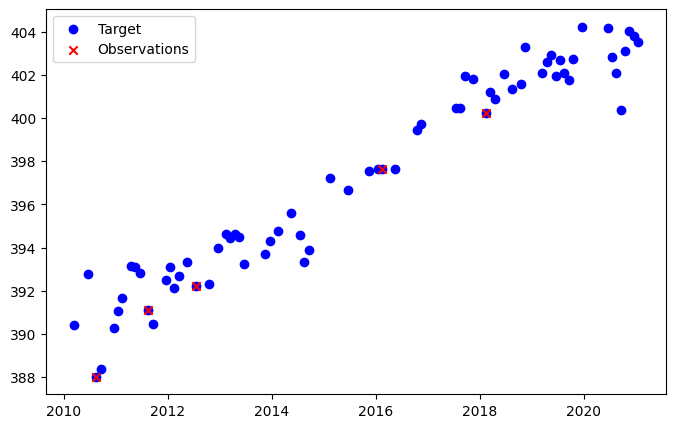

In [9]:
for (context_x, context_y, target_x), target_y in data_generator.train_ds.take(5):
    RegressionDataGenerator.plot_first_elt_of_batch(context_x, context_y, target_x, target_y)

In [16]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from model import ConditionalNeuralProcess

encoder_dims = [500, 500, 500, 500]
decoder_dims = [500, 500, 500, 2]

def loss(target_y, pred_y):
    # Get the distribution
    mu, sigma = tf.split(pred_y, num_or_size_splits=2, axis=-1)
    dist = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    return -dist.log_prob(target_y)

model = ConditionalNeuralProcess(encoder_dims, decoder_dims)
model.compile(loss=loss, optimizer='adam')

In [17]:
model.fit(data_generator.train_ds, validation_data=data_generator.test_ds, epochs=1)

250/250 [==============================] - 143s 572ms/step - loss: 180462.2188 - val_loss: 5.5892


In [13]:
from utils.gaussian_processes.plot_gp_utils import plot_preds_from_ds_test

1/1 [==============================] - 0s 31ms/step


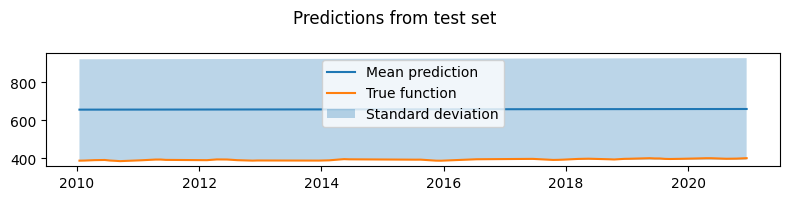

In [14]:
fig = plot_preds_from_ds_test(model, ds_test=data_generator.test_ds, num_samples=1)

1/1 [==============================] - 0s 28ms/step


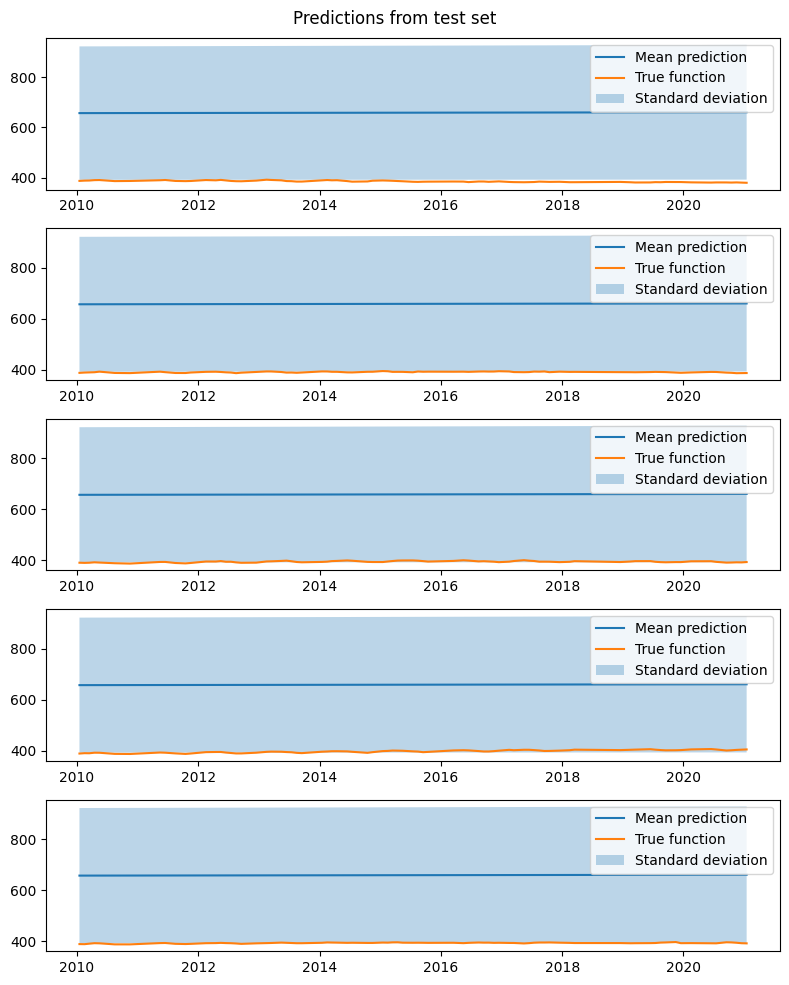

In [15]:
fig = plot_preds_from_ds_test(model, ds_test=data_generator.test_ds, num_samples=5)